## Part 1 : Preprocessing <a class="anchor" id="chapter1"></a>

### Part 1.1 : Libraries & data loading <a class="anchor" id="section_1_1"></a>

Do this in order to install Reddit Python library:
`pip install praw`.

Library docs: https://praw.readthedocs.io/en/stable/getting_started/quick_start.html



Now we need to setup Reddit data fetching. For this we need to have a Reddit account.

We'll use posts from https://www.reddit.com/r/Paranormal/comments/gc4ive/i_made_another_big_list_of_paranormal_and_mystery/ for inspiration.

Now, create `client_id` and `client_secret`.

How?
  - Create a Reddit account if you don't have one yet
  - Go to https://www.reddit.com/prefs/apps and click `create an app`
  - Pick `script` app type. Name and description can be anything, but make sure to specify `http://localhost:8080` as `redirect uri`
  - Press `create app`. Your `client_id` is the string under **personal use script** and `client_secret` is the string next to **secret**

In [9]:
import praw
import pandas as pd

reddit = praw.Reddit(
    client_id = 'uht5aeWYy62NR09OUSPy5g',
    client_secret = 'e52jSv2kqUBmzpAQipVHixCP1VKQmg',
    user_agent = 'praw'
)

# This function returns a Pandas dataframe
# containing reddit post comments, given its id
def getComments(id):
    submission = reddit.submission(id)
    pandas_list = []
    commentsList = submission.comments.list()
    # 'limit' parameter can be increased 
    # in order to expand more comments
    submission.comments.replace_more(limit=64)
    print(len(commentsList))
    i = 0
    for c in commentsList:
        if isinstance(c, praw.models.MoreComments):
            continue
        commentText = c.body
        if commentText in {'[deleted]', '[removed]'}:
            continue
        pandas_list.append([i, commentText])
        i+=1
    df = pd.DataFrame(pandas_list)
    df.columns = ['id', 'description']
    return df

Install wordcloud.

`pip install wordcloud`

1. Import pandas, numpy, sklearn (TfidfVectorizer, DBSCAN and TruncatedSVD), matplotlib and wordcloud.

In [13]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN


import matplotlib.pyplot as plt
import wordcloud

2. Read reddit comments and put it in a DataFrame named `corpus`.

In [17]:
corpus = getComments('1c9i51g')

693


In [19]:
print(corpus.shape)
corpus.head()

(495, 2)


,id,description
0,0,Coming into work on my day off.
1,1,Tight caves. I don't want to end up in Mr ball...
2,2,‘Are you on Facebook?’
3,3,"Skydiving, bungee jumping and Meth. Definitely..."
4,4,Celery and a Nigerian millionaire prince askin...


In [21]:
print('First spooky story : ',corpus.loc[0,'description'])

First spooky story :  Coming into work on my day off.


### Part 1.2 : Text preprocessings <a class="anchor" id="section_1_2"></a>

3. Use `str` methods to clean the texts. Save cleaned-up text into a column named `clean_description`.

In [25]:
# Remove HTML elements
corpus['clean_description'] = corpus['description'].str.replace(r"<[a-z/]+>", " ") 
# Remove special characters and numbers
corpus['clean_description'] = corpus['clean_description'].str.replace(r"[^A-Za-z]+", " ") 
print('Description cleaned of the first product : ',corpus.loc[0,'clean_description'])

Description cleaned of the first product :  Coming into work on my day off.


4. Tranform every character into lowercase.

In [28]:
# Lowercase
corpus['clean_description'] = corpus['clean_description'].str.lower()
print('First story lower-cased : ',corpus.loc[0,'clean_description'])

First story lower-cased :  coming into work on my day off.


5. Use NLTK to tokenize the documents and put the result in a new column named `clean_tokens`.

In [31]:
## Tokenize the cleaned description
from nltk.tokenize import word_tokenize
corpus['clean_tokens'] = corpus['clean_description'].apply(lambda x: word_tokenize(x))
corpus.head()

,id,description,clean_description,clean_tokens
0,0,Coming into work on my day off.,coming into work on my day off.,"[coming, into, work, on, my, day, off, .]"
1,1,Tight caves. I don't want to end up in Mr ball...,tight caves. i don't want to end up in mr ball...,"[tight, caves, ., i, do, n't, want, to, end, u..."
2,2,‘Are you on Facebook?’,‘are you on facebook?’,"[‘, are, you, on, facebook, ?, ’]"
3,3,"Skydiving, bungee jumping and Meth. Definitely...","skydiving, bungee jumping and meth. definitely...","[skydiving, ,, bungee, jumping, and, meth, ., ..."
4,4,Celery and a Nigerian millionaire prince askin...,celery and a nigerian millionaire prince askin...,"[celery, and, a, nigerian, millionaire, prince..."


6. Remove the stop words and lemmatize `clean_tokens`. We'll use the code we had in lab2.

In [34]:
# Remove stop words
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag
stop_words = set(stopwords.words('english'))


 
lemmatizer = WordNetLemmatizer()
def lemmatize(tokens):
    stopWordsRemoved = [t for t in tokens if t not in stop_words]
    lemmatized_sentence = []
    for word, tag in pos_tag(stopWordsRemoved):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))   
    return lemmatized_sentence
    
# Lemmatize
corpus['clean_tokens'] = corpus['clean_tokens'].apply(lambda x: lemmatize(x))
corpus.head()

,id,description,clean_description,clean_tokens
0,0,Coming into work on my day off.,coming into work on my day off.,"[come, work, day, .]"
1,1,Tight caves. I don't want to end up in Mr ball...,tight caves. i don't want to end up in mr ball...,"[tight, cave, ., n't, want, end, mr, ballen, v..."
2,2,‘Are you on Facebook?’,‘are you on facebook?’,"[‘, facebook, ?, ’]"
3,3,"Skydiving, bungee jumping and Meth. Definitely...","skydiving, bungee jumping and meth. definitely...","[skydiving, ,, bungee, jumping, meth, ., defin..."
4,4,Celery and a Nigerian millionaire prince askin...,celery and a nigerian millionaire prince askin...,"[celery, nigerian, millionaire, prince, ask, m..."


In [36]:
lemmatize(["scariest", "passed"])

['scariest', 'pass']

7. Write all the cleaned tokens into one single string and put it in a new column named `clean_document`.

In [39]:
# Put back tokens into one single string
corpus["clean_document"] = [" ".join(x) for x in corpus['clean_tokens']]
corpus.head()

,id,description,clean_description,clean_tokens,clean_document
0,0,Coming into work on my day off.,coming into work on my day off.,"[come, work, day, .]",come work day .
1,1,Tight caves. I don't want to end up in Mr ball...,tight caves. i don't want to end up in mr ball...,"[tight, cave, ., n't, want, end, mr, ballen, v...",tight cave . n't want end mr ballen video
2,2,‘Are you on Facebook?’,‘are you on facebook?’,"[‘, facebook, ?, ’]",‘ facebook ? ’
3,3,"Skydiving, bungee jumping and Meth. Definitely...","skydiving, bungee jumping and meth. definitely...","[skydiving, ,, bungee, jumping, meth, ., defin...","skydiving , bungee jumping meth . definitely m..."
4,4,Celery and a Nigerian millionaire prince askin...,celery and a nigerian millionaire prince askin...,"[celery, nigerian, millionaire, prince, ask, m...",celery nigerian millionaire prince ask money


### Part 1 conclusion :
Now we have the `clean_document` feature which is cleaned. We can train some NLP model on it.

## Part 2 - Clustering model --> Identify similar products <a class="anchor" id="chapter2"></a>

1. Perform TF-IDF transformation using the data from the column `clean_document`.

In [44]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus["clean_document"])

# X is a generator. We can transform that as an array
X = X.toarray()
print(X.shape)

(495, 1638)


In [46]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [48]:
# Print the 50 first words into our vocabulary
print(sorted(vectorizer.vocabulary_.items())[:50])

[('00', 0), ('10', 1), ('100', 2), ('1000', 3), ('11', 4), ('13', 5), ('16', 6), ('19', 7), ('1st', 8), ('20', 9), ('2000', 10), ('2023', 11), ('20s', 12), ('22', 13), ('2nd', 14), ('2x', 15), ('30', 16), ('36', 17), ('37', 18), ('40', 19), ('43', 20), ('4s', 21), ('50', 22), ('51', 23), ('57', 24), ('5x', 25), ('80', 26), ('90', 27), ('92', 28), ('99', 29), ('ability', 30), ('able', 31), ('absolutely', 32), ('abusive', 33), ('academic', 34), ('accept', 35), ('accepted', 36), ('access', 37), ('accident', 38), ('accidentally', 39), ('accord', 40), ('accusation', 41), ('achieve', 42), ('acid', 43), ('acknowledge', 44), ('acquaintance', 45), ('action', 46), ('activity', 47), ('actually', 48), ('add', 49)]


2. Create a DataFrame containing the result from TF-IDF

In [51]:
# Create a dataframe with tf-idf
X_df = pd.DataFrame(X, 
             columns=vectorizer.get_feature_names_out(), 
             index=["item_{}".format(x) for x in range(corpus.shape[0])] )

X_df.head()

,00,10,100,1000,11,13,16,19,1st,20,...,yes,yesterday,young,youth,youtube,yt,yup,zealot,zero,zipper
item_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Each line of X correspond to a story.
- Each column of X correspond to a word in the vocabulary.
- So each cell of X correspond to the score TF-IDF for a word in a particular story.

3. Use DBSCAN to make some clustering on the TF-IDF matrix.

DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. It belongs to the unsupervised learning family of clustering algorithms.

When it comes to clustering, usually K-means or Hierarchical clustering algorithms are more popular. But they work well only when the clusters are simple to detect. They will not produce good results when the clusters have complex shapes or structures and this is where the DBSCAN algorithm gets the upper hand.

- When dealing with texts, the distance metric to be used is cosine instead of euclidean 
- eps = 0.7 and min samples = 3 enable to have almost 15 clusters without too much outliers

In [53]:
# Clustering on documents with DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=3, metric="cosine", algorithm="brute")

# Fit on data 
#No need to normalize data, it already is due to TF-IDF
clustering.fit(X)

# Write cluster ids into corpus and X_df
corpus['cluster_id'] = clustering.labels_
display(corpus.head())
X_df['cluster_id'] = clustering.labels_
display(X_df.head())

,id,description,clean_description,clean_tokens,clean_document,cluster_id
0,0,Coming into work on my day off.,coming into work on my day off.,"[come, work, day, .]",come work day .,0
1,1,Tight caves. I don't want to end up in Mr ball...,tight caves. i don't want to end up in mr ball...,"[tight, cave, ., n't, want, end, mr, ballen, v...",tight cave . n't want end mr ballen video,-1
2,2,‘Are you on Facebook?’,‘are you on facebook?’,"[‘, facebook, ?, ’]",‘ facebook ? ’,1
3,3,"Skydiving, bungee jumping and Meth. Definitely...","skydiving, bungee jumping and meth. definitely...","[skydiving, ,, bungee, jumping, meth, ., defin...","skydiving , bungee jumping meth . definitely m...",0
4,4,Celery and a Nigerian millionaire prince askin...,celery and a nigerian millionaire prince askin...,"[celery, nigerian, millionaire, prince, ask, m...",celery nigerian millionaire prince ask money,2


,00,10,100,1000,11,13,16,19,1st,20,...,yesterday,young,youth,youtube,yt,yup,zealot,zero,zipper,cluster_id
item_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
item_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
item_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
item_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
item_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


4. Display number of documents in each cluster

In [56]:
# Number of documents in each cluster
corpus['cluster_id'].value_counts()

cluster_id
-1     294
 0     128
 4      13
 1       5
 3       5
 5       5
 11      5
 17      4
 8       4
 6       4
 14      4
 7       3
 10      3
 9       3
 12      3
 13      3
 2       3
 15      3
 16      3
Name: count, dtype: int64

5. Print a sample of 3 documents that belong to 5 clusters

In [59]:
# Print sample of 3 documents for the 5 first cluster
for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c , ' :')
    print('----')
    for d in corpus.loc[corpus['cluster_id']==c,:].sample(3)['clean_description']:
        print(d)
        print()
    print('-----------')

CLUSTER  -1  :
----
i might drink alcohol on very specific stuff, but i'm also quite certain i never want to be a drunk so i stat away

not even once

jehova’s witnesses

-----------
CLUSTER  0  :
----
i don't like them either, they smell so bad

it is awesome!

and the way it's made is cruel.

-----------
CLUSTER  4  :
----
i like cooked onions, but not raw onions. i feel alienated from two different subs now.

heroin

liver and onions!

-----------
CLUSTER  1  :
----
facebook

facebook group halifax noise gets around that by posting a picture, story intro and then a link on where to find more. not sure how they don’t get their stuff taken down. but facebook has beyond horrid control on their community of standards

in canada, the government insisted that facebook pay the news providers for their content.  facebook said “no” and pulled it from their site.  meta thought that people would complain to the government about it.  nope, there was very little public outrage over it.

--------

6. Print the 5 most frequent words in the 5 first clusters

In [62]:
# 5 Most frequent words in each cluster
cols = [c for c in X_df.columns if c!='cluster_id']

for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c)
    print(X_df.loc[X_df['cluster_id']==c,cols].mean(axis=0).sort_values(ascending=False)[0:5])
    print('-----------')

CLUSTER  -1
like      0.022705
know      0.015804
make      0.015224
people    0.013705
time      0.013567
dtype: float64
-----------
CLUSTER  0
drug    0.058234
meth    0.048879
say     0.048857
work    0.042659
good    0.039526
dtype: float64
-----------
CLUSTER  4
heroin    0.345474
liver     0.229564
onion     0.203635
table     0.092371
year      0.077553
dtype: float64
-----------
CLUSTER  1
facebook      0.621561
news          0.099917
government    0.084713
ban           0.078543
weird         0.073654
dtype: float64
-----------
CLUSTER  3
relationship    0.515463
open            0.427722
tried           0.245043
stern           0.145889
worth           0.108236
dtype: float64
-----------


7. Wordcloud for the 5 first clusters

CLUSTER  -1


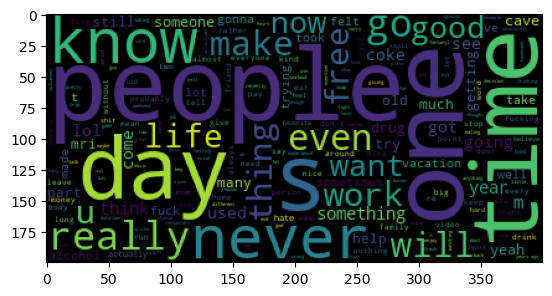

-----------
CLUSTER  0


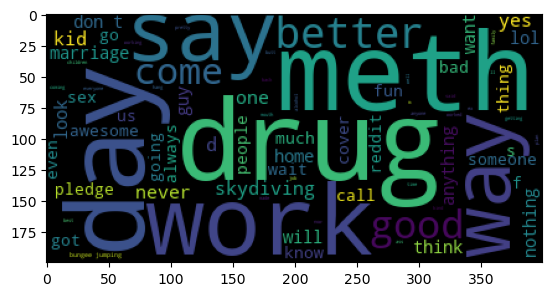

-----------
CLUSTER  4


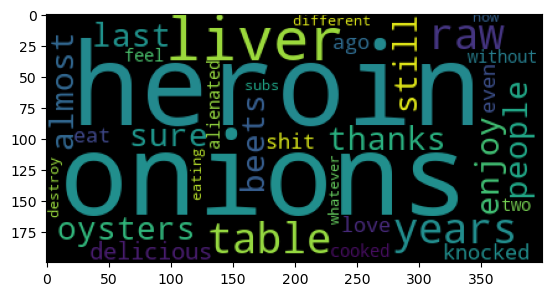

-----------
CLUSTER  1


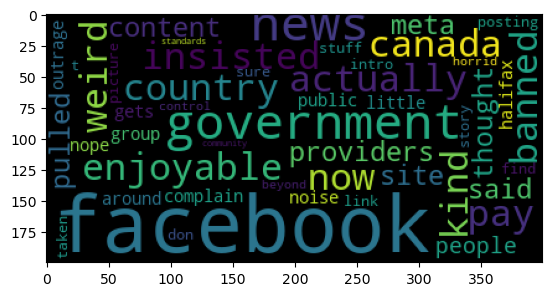

-----------
CLUSTER  3


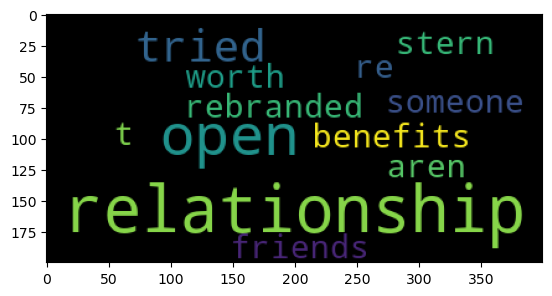

-----------


In [65]:
# Word cloud for the 5 first clusters
wd = wordcloud.WordCloud()
for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c)
    texts = " ".join(corpus.loc[corpus['cluster_id']==c,'clean_description'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    print('-----------')

## Part 3 - LSA for topic extraction <a class="anchor" id="chapter4"></a>

- Latent Semantic Analysis, or LSA, is one of the foundational techniques in topic modeling. The core idea is to take a matrix of what we have — documents and terms — and decompose it into a separate document-topic matrix and a topic-term matrix.

- The main goal of this part is to find relevant topics for each documents. Contrary to clustering, a unique documents can have multiple topics. For example, Ghosts and UFOs.

1. Use TruncatedSVD to make some topic extraction from the TF-IDF matrix.

In [67]:
from sklearn.decomposition import TruncatedSVD
# Train SVD model
svd_model = TruncatedSVD(n_components=12) # We test on 12 topics
lsa = svd_model.fit_transform(X)
topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_" + str(i) for i in range(lsa.shape[1])])
topic_encoded_df["documents"] = corpus['clean_description']
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents
0,0.331499,-0.199082,-0.307631,0.011168,-0.324427,0.602457,0.008531,-0.117114,-0.022773,-0.024255,-0.043387,-0.041523,coming into work on my day off.
1,0.068754,-0.027269,0.003349,0.049220,-0.005751,-0.023611,0.014672,0.118488,0.017404,-0.051373,-0.227412,-0.052474,tight caves. i don't want to end up in mr ball...
2,0.026754,-0.014649,0.020535,-0.009701,-0.013113,-0.035297,-0.017260,0.084630,-0.005925,0.033285,-0.002002,-0.033430,‘are you on facebook?’
3,0.103242,-0.076593,0.395028,0.553148,-0.078967,0.046535,0.032143,-0.036832,-0.044506,0.043027,-0.003887,0.003039,"skydiving, bungee jumping and meth. definitely..."
4,0.024729,-0.014287,-0.012093,-0.006870,0.005785,0.006602,0.001234,0.029283,-0.015030,0.055230,-0.001354,0.030003,celery and a nigerian millionaire prince askin...


In [69]:
lsa

array([[ 0.33149875, -0.19908241, -0.30763088, ..., -0.02425495,
        -0.04338673, -0.04152309],
       [ 0.0687544 , -0.02726944,  0.00334941, ..., -0.05137257,
        -0.22741161, -0.05247361],
       [ 0.02675353, -0.01464902,  0.02053451, ...,  0.03328463,
        -0.00200153, -0.03342975],
       ...,
       [ 0.05102752, -0.02706945,  0.04841997, ..., -0.05469073,
         0.02215809, -0.05167992],
       [ 0.03246313, -0.00567069,  0.00374259, ...,  0.02148387,
        -0.04636836,  0.0048958 ],
       [ 0.12582972, -0.06124179, -0.06593298, ..., -0.03013758,
         0.04494435, -0.01446864]])

Contrary to clustering, LSA allows to map each document to a mix of several topics. For this reason, it's a bit more difficult to interpret the topics as categories : one document can actually be related to several topics at a time. To make things easier, we can extract the main topic of each document.

2. Create a new column named `main_topic` in `topic_encoded_df` where we store the main topics related to each document.

In [73]:
def extract_main_topics(x):
    """
    Return the main topic for each document. The main topic is that have the maximum value for each line
    """
    topics = np.abs(x)
    main_topic = topics.sort_values(ascending=False).index[0]
    return main_topic

# Initialize column main_topics with 0
topic_encoded_df.loc[:, 'main_topic'] = 0

for i, row in topic_encoded_df.iloc[:,:-2].iterrows():
    topic_encoded_df.loc[i, 'main_topic'] = extract_main_topics(row)

topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,0.331499,-0.199082,-0.307631,0.011168,-0.324427,0.602457,0.008531,-0.117114,-0.022773,-0.024255,-0.043387,-0.041523,coming into work on my day off.,topic_5
1,0.068754,-0.027269,0.003349,0.049220,-0.005751,-0.023611,0.014672,0.118488,0.017404,-0.051373,-0.227412,-0.052474,tight caves. i don't want to end up in mr ball...,topic_10
2,0.026754,-0.014649,0.020535,-0.009701,-0.013113,-0.035297,-0.017260,0.084630,-0.005925,0.033285,-0.002002,-0.033430,‘are you on facebook?’,topic_7
3,0.103242,-0.076593,0.395028,0.553148,-0.078967,0.046535,0.032143,-0.036832,-0.044506,0.043027,-0.003887,0.003039,"skydiving, bungee jumping and meth. definitely...",topic_3
4,0.024729,-0.014287,-0.012093,-0.006870,0.005785,0.006602,0.001234,0.029283,-0.015030,0.055230,-0.001354,0.030003,celery and a nigerian millionaire prince askin...,topic_9


3. Count each main topic in the corpus 

In [76]:
topic_encoded_df['main_topic'].value_counts()

main_topic
topic_0     109
topic_10     63
topic_7      60
topic_11     54
topic_9      46
topic_6      37
topic_5      36
topic_8      20
topic_4      19
topic_3      18
topic_1      18
topic_2      15
Name: count, dtype: int64

- topic_0 is the most represented topic, as it's the main topic for more than `50%` of the documents of the corpus.

4. Use the attribute `components_` of the SVD model to print the 5 most important words in each topic.

In [80]:
# Create DataFrame containing the description of each topic in terms of the words in the vocabulary
topics_description = pd.DataFrame(svd_model.components_, columns = vectorizer.get_feature_names_out(), 
                                  index = ['topic_' + str(i) for i in range(svd_model.components_.shape[0])])

# Compute absolute values of coefficients
topics_description = topics_description.apply(np.abs, axis = 1)

# Each word is map with a score of relevance for each topic
topics_description.head()

,00,10,100,1000,11,13,16,19,1st,20,...,yes,yesterday,young,youth,youtube,yt,yup,zealot,zero,zipper
topic_0,0.002744,0.008966,0.010317,0.002519,0.007873,0.004142,0.001337,0.002273,0.003590,0.008484,...,0.058994,0.007278,0.008171,0.006312,0.007413,0.002519,0.004446,0.002645,0.000989,0.000598
topic_1,0.001321,0.005398,0.009719,0.001161,0.004663,0.001361,0.000373,0.000039,0.000561,0.002989,...,0.031299,0.003863,0.002933,0.003094,0.002988,0.001161,0.001820,0.000515,0.000477,0.000210
topic_2,0.001858,0.004026,0.000831,0.000420,0.002355,0.001730,0.000299,0.001257,0.001011,0.000170,...,0.131632,0.004194,0.004302,0.004148,0.001538,0.000420,0.000823,0.002410,0.000884,0.000274
topic_3,0.000053,0.002153,0.000709,0.001409,0.004171,0.000262,0.001193,0.000517,0.000488,0.007578,...,0.040940,0.000130,0.000575,0.000870,0.000342,0.001409,0.000620,0.000543,0.000158,0.000492
topic_4,0.000401,0.008447,0.002678,0.000256,0.007471,0.006987,0.002306,0.001422,0.002344,0.008101,...,0.005690,0.002458,0.000501,0.001467,0.001105,0.000256,0.000957,0.000357,0.000473,0.000200


In [82]:
# Loop over each topic and print the 5 most important words
for i,row in topics_description.iterrows():
    print('TOPIC :', i)
    print(row.sort_values(ascending=False)[0:5].index.tolist())
    print()
    print('-------------------------')
    print()

TOPIC : topic_0
['drug', 'like', 'say', 'work', 'day']

-------------------------

TOPIC : topic_1
['drug', 'say', 'like', 'work', 'good']

-------------------------

TOPIC : topic_2
['say', 'meth', 'work', 'like', 'come']

-------------------------

TOPIC : topic_3
['meth', 'say', 'kid', 'marriage', 'bungee']

-------------------------

TOPIC : topic_4
['heroin', 'onion', 'work', 'liver', 'year']

-------------------------

TOPIC : topic_5
['work', 'like', 'heroin', 'come', 'day']

-------------------------

TOPIC : topic_6
['good', 'like', 'pledge', 'word', 'job']

-------------------------

TOPIC : topic_7
['good', 'people', 'post', 'like', 'make']

-------------------------

TOPIC : topic_8
['relationship', 'open', 'tried', 'worth', 'rebranded']

-------------------------

TOPIC : topic_9
['way', 'post', 'copy', 'people', 'credit']

-------------------------

TOPIC : topic_10
['post', 'work', 'way', 'want', 'religion']

-------------------------

TOPIC : topic_11
['religion', 'smok

5. Make a wordcloud describing each topic and compare to the ones we obtain with clustering

In [85]:
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,0.331499,-0.199082,-0.307631,0.011168,-0.324427,0.602457,0.008531,-0.117114,-0.022773,-0.024255,-0.043387,-0.041523,coming into work on my day off.,topic_5
1,0.068754,-0.027269,0.003349,0.049220,-0.005751,-0.023611,0.014672,0.118488,0.017404,-0.051373,-0.227412,-0.052474,tight caves. i don't want to end up in mr ball...,topic_10
2,0.026754,-0.014649,0.020535,-0.009701,-0.013113,-0.035297,-0.017260,0.084630,-0.005925,0.033285,-0.002002,-0.033430,‘are you on facebook?’,topic_7
3,0.103242,-0.076593,0.395028,0.553148,-0.078967,0.046535,0.032143,-0.036832,-0.044506,0.043027,-0.003887,0.003039,"skydiving, bungee jumping and meth. definitely...",topic_3
4,0.024729,-0.014287,-0.012093,-0.006870,0.005785,0.006602,0.001234,0.029283,-0.015030,0.055230,-0.001354,0.030003,celery and a nigerian millionaire prince askin...,topic_9


-------------------------

TOPIC  topic_0


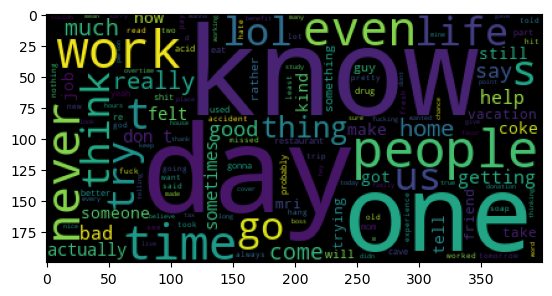


-------------------------

TOPIC  topic_1


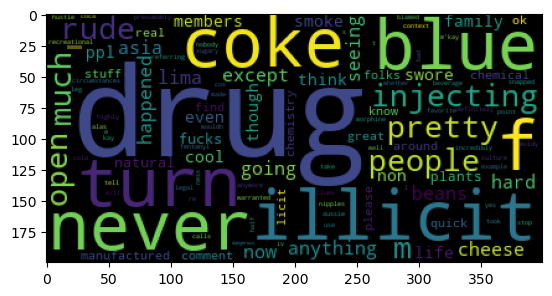


-------------------------

TOPIC  topic_2


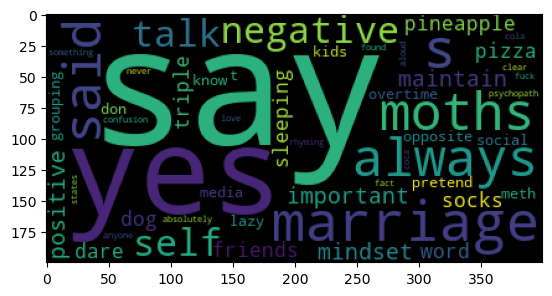


-------------------------

TOPIC  topic_3


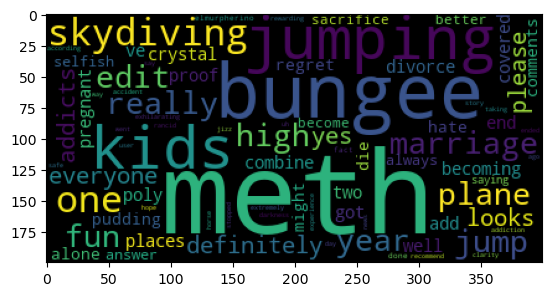


-------------------------

TOPIC  topic_4


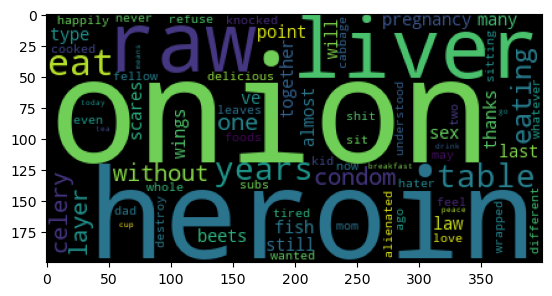


-------------------------

TOPIC  topic_5


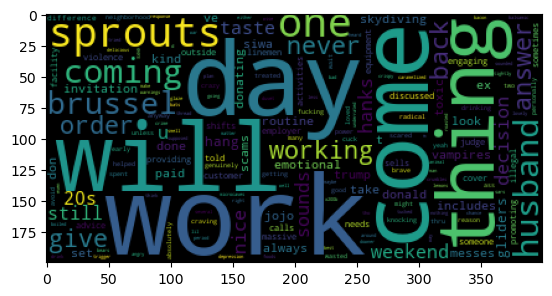


-------------------------

TOPIC  topic_6


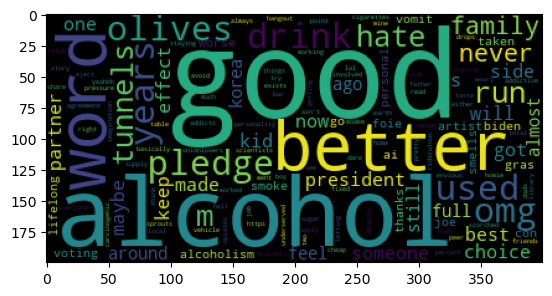


-------------------------

TOPIC  topic_7


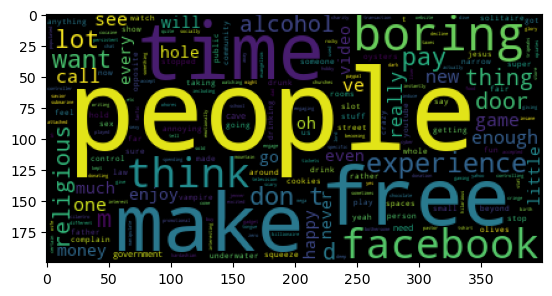


-------------------------

TOPIC  topic_8


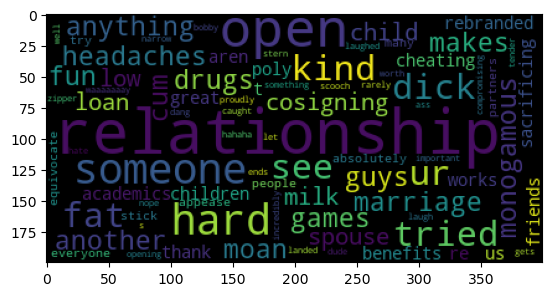


-------------------------

TOPIC  topic_9


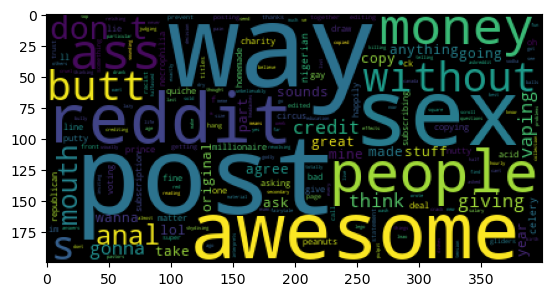


-------------------------

TOPIC  topic_10


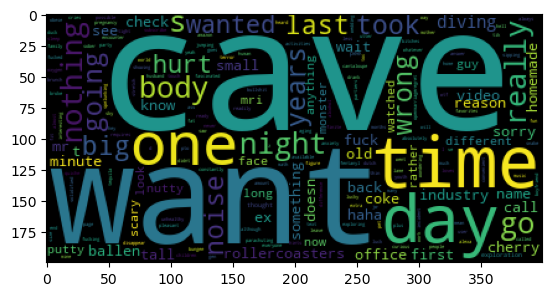


-------------------------

TOPIC  topic_11


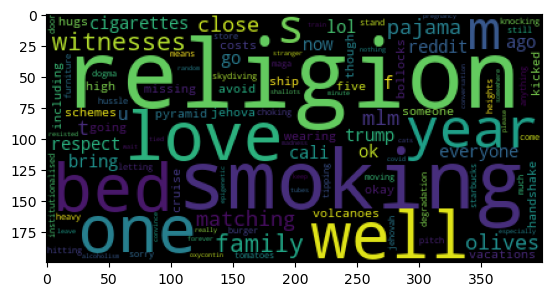

In [87]:
# Loop over each topic and create wordcloud from documents that are related to this main topic
wd = wordcloud.WordCloud()

cols = [c for c in topic_encoded_df.columns if 'topic_' in c]

for t in cols:
    print('-------------------------')
    print()
    print('TOPIC ', t)
    
    # Handle topics that are not main topics for any document in the corpus
    if (topic_encoded_df['main_topic']==t).any() == False :
        print('cannot create wordcloud for this topic')
        continue
    
    texts = " ".join(topic_encoded_df.loc[topic_encoded_df['main_topic']==t,'documents'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    
    print()

## Conclusion

- It's difficult to compare the results from the clustering and LSA, in particular because we didn't get exactly the same number of "topics" for both algorithms. However, the wordclouds are not fundamentally different (for example, both algorithms identify a group of documents or topic related to sun protection, organic cotton or merino wood).

- The major difference between these two approaches is that clustering maps a given document to a single group, whereas LSA links a document to several topics. For this reason, text clustering is usually more suitable for applications related to similarity measurements (for example, building a recommender system),  whereas LSA is widely used for topic modelling.